# 32x32 expGP image reconstruction with GEDA

Image reconstruction.

In [152]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import numpy as np
import torch
from torch import nn

import swyft
from swyft.utils.ns import SwyftSimpleSliceSampler
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive, LogRatioEstimator_Gaussian, LogRatioEstimator_Autoregressive_Gaussian

import pylab as plt

#import pytorch_lightning as pl

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [154]:
class GEDA:
    """Gibbs sampler for MVN based on exact data augmentation (GEDA).
    
    The underlying assumption is that the precision matrix can be split as follows:
    
    Q = Q1 + Q2
    Q1 = G1.T L1 G1  (G1 is arbitrary, D1 is diagonal*)
    Q2 = U2.T D2 U2  (U2 is unitary, D2 is diagonal)
    
    omega is a positive hyper-parameter of the algorithm
    it must obey omega < 1/||Q1|| (1/omega should be larger than the largest singular value of Q1)
    
    * In GEDA D1 just has to be positive definite.
    """
    def __init__(self, omega, G1, D1, G1T, U2, D2, U2T):
        """
        Arguments:
            omega: float
            G1: Callable
            D1: Vector
            G1T: Callable
            U2: Callable
            D2: Vector
            U2T: Callable
        """
        self.omega = omega
        self.N = len(D2)
        self.G1 = G1
        self.D1 = D1
        self.G1T = G1T
        self.U2 = U2
        self.D2 = D2
        self.U2T = U2T
        
        self.device = self.D1.device
        
        # Aux definitions
        self.Q1 = lambda x: self.G1T(self.D1*self.G1(x))
        self.R = lambda x: x/self.omega - self.Q1(x)
        
    def _gibbs_sample_step(self, theta, u1):
        mu_u2 = self.G1(u1)
        u2 = mu_u2+torch.randn(self.N).to(self.device)/self.D1**0.5
        mu_u1 = theta - self.omega*(self.Q1(theta)-self.G1T(u2/self.D1))
        u1 = mu_u1 + torch.randn(self.N).to(self.device)*self.omega**0.5
        
        mu_U2_theta = (1/self.omega + self.D2)**-1*self.U2((self.R(u1)+0))
        theta = self.U2T(mu_U2_theta + torch.randn(self.N).to(self.device)/(1/self.omega + self.D2)**0.5)
        
        return theta, u1
    
    def sample(self, N, steps = 100):
        "Generate N samples"
        samples = []
        for i in range(N):
            if i == 0:
                theta = self.U2T(torch.randn(self.N).to(self.device)/(0/self.omega + self.D2)**0.5) # Sample from Q2
                u1 = torch.randn(self.N).to(self.device)*self.omega**0.5  # Sample u1 assuming theta = u2 = 0
            for _ in range(steps):
                theta, u1 = geda._gibbs_sample_step(theta, u1)
            samples.append(theta)
        return samples

In [158]:
N = 1000
K = 100
device = 'cuda'


Sigma = torch.zeros((N, N)).to(device).double()
Sigma[:K,:K] += 0.1
Sigma[K:, K:] += torch.eye(N-K).to(device)*1
Sigma[:K, :K] += torch.eye(K).to(device)*0.001
Q1 = torch.linalg.inv(Sigma)
G1 = torch.linalg.cholesky(Q1).T.float()

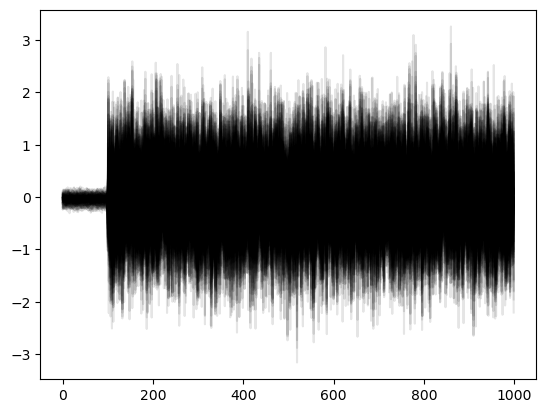

In [159]:
D1 = torch.ones(N).to(device)
D2 = torch.ones(N).to(device)

geda = GEDA(1e-3, lambda x: torch.matmul(G1, x), D1, lambda x: torch.matmul(G1.T, x), lambda x: x, D2, lambda x: x)
samples = geda.sample(100)
for s in samples:
    plt.plot(s.cpu().numpy()[:], alpha = 0.1, color = 'k')

In [247]:
Npix = 128
N = Npix**2
print(N)

l = torch.arange(Npix)
L1, L2 = torch.meshgrid(l, l)
L = torch.stack([L1, L2], dim = -1)
T = L.unsqueeze(0).unsqueeze(0) - L.unsqueeze(2).unsqueeze(2)
T = (T**2).sum(-1)**0.5
T = T.view(N, N)
Cov = torch.exp(-T/16)*0.5 + torch.exp(-T/8)*.25 + torch.exp(-T/4)*.125

dist = torch.distributions.MultivariateNormal(torch.zeros(N), Cov)

16384


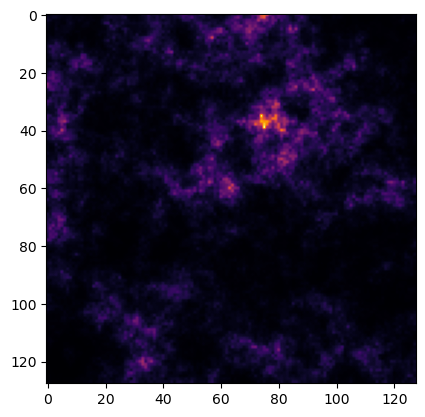

In [248]:
def sample_GP(N, gamma = 3):
    #z = np.random.multivariate_normal(np.zeros(N), Cov.numpy()).reshape(Npix, Npix)
    z = dist.sample(torch.Size([1]))[0].numpy().reshape(Npix, Npix)
    return z

z = sample_GP(N, gamma = 2.5)
plt.imshow(np.exp(z), cmap='inferno')

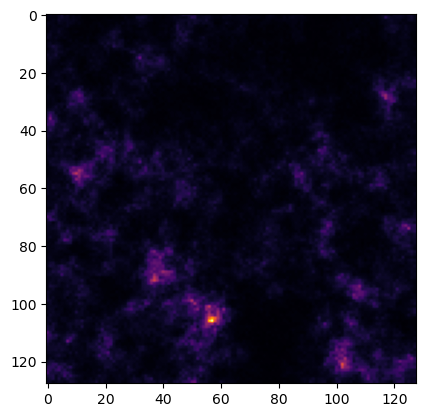

In [249]:
class Sim(swyft.Simulator):
    def __init__(self, sigma = .1, bounds = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sigma = sigma    
        self.bounds = bounds
        
    def sample_GP(self):
        if self.bounds is None:
            return sample_GP(N, gamma = 2.5)
        else:
            i = np.random.randint(len(self.bounds))
            return self.bounds[i]
            
  
    def build(self, graph):
        z = graph.node("z", lambda: self.sample_GP())
        y = graph.node("y", lambda z: np.exp(z), z)
        x = graph.node("x", lambda y: y + np.random.randn(Npix, Npix)*self.sigma, y)
        
        
sim = Sim()
s = sim.sample()
plt.imshow(s['x'], cmap='inferno')

In [250]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, D = 100):
        super().__init__()

        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.num_params = D
        self.lre = LogRatioEstimator_Autoregressive_Gaussian(D, "mu")
        self.l = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, A, B):
        x = A["x"].view(-1, N)
        f = self.l(x.unsqueeze(-1)).squeeze(-1)
        result = self.lre(f, A['z'].view(-1,N), B['z'].view(-1, N))
        return result

In [252]:
samples = sim.sample(10000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [253]:
net = Network(D=N)

In [254]:
net.lre._momentum = 0.01

In [265]:
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 20)
trainer.fit(net, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                      | Params
-------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Autoregressive_Gaussian | 805 M 
1 | l    | Sequential                                | 16.9 K
-------------------------------------------------------------------
536 M     Trainable params
268 M     Non-trainable params
805 M     Total params
3,221.293 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

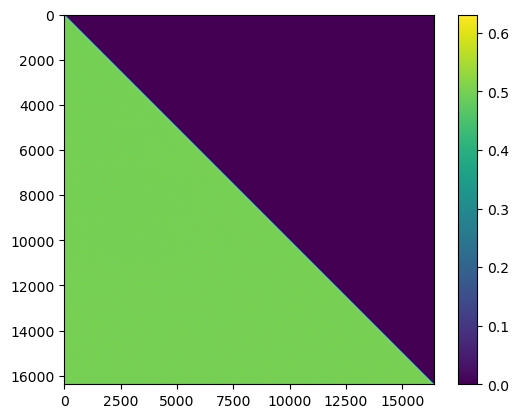

In [266]:
Phi = net.lre.Phi.detach().cpu().numpy()
plt.imshow(Phi)
plt.colorbar()

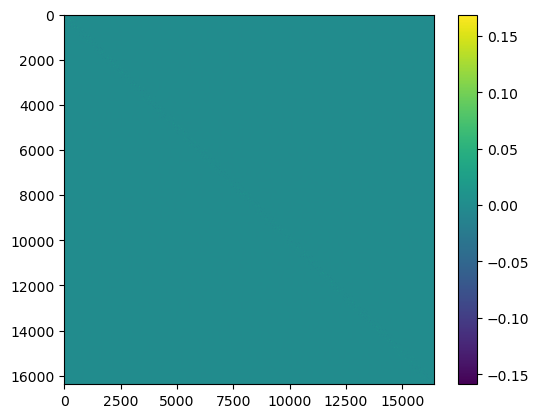

In [267]:
B = net.lre.B.weight.detach().cpu().numpy()
plt.imshow(B)
plt.colorbar()

In [271]:
i = np.random.randint(len(samples))
print(i)
sample0 = samples[i]

4222


/tmp/ipykernel_329081/1071123716.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = net.l(torch.tensor(x).cuda().unsqueeze(-1)).squeeze(-1).detach()[0]


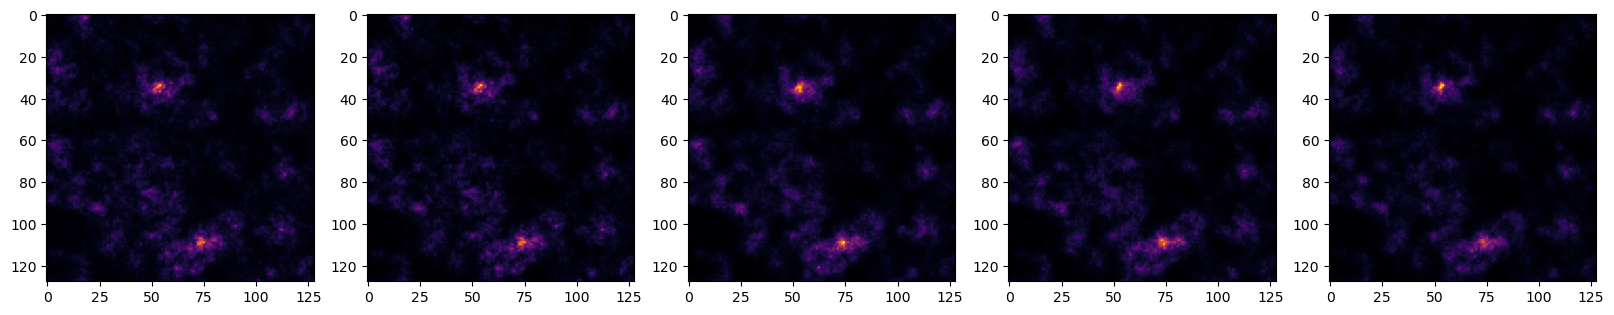

In [272]:
Cov = Cov.double().cuda()
x = torch.tensor(sample0['x']).view(-1, N)
y = torch.tensor(sample0['y']).view(-1, N)
f = net.l(torch.tensor(x).cuda().unsqueeze(-1)).squeeze(-1).detach()[0]

#print(f.shape)
draws = net.lre.get_samples(10000, f, cov = Cov*1, gamma = 1.0).view(-1, Npix, Npix).cpu()

plt.figure(figsize=(20, 5))
plt.subplot(1,5,1)
plt.imshow(x.view(Npix,Npix), cmap='inferno')
plt.subplot(1,5,2)
plt.imshow(y.view(Npix,Npix), cmap='inferno')
for i in range(3):
    plt.subplot(1, 5, i+3)
    plt.imshow(np.exp(draws[i].cpu()), cmap='inferno')

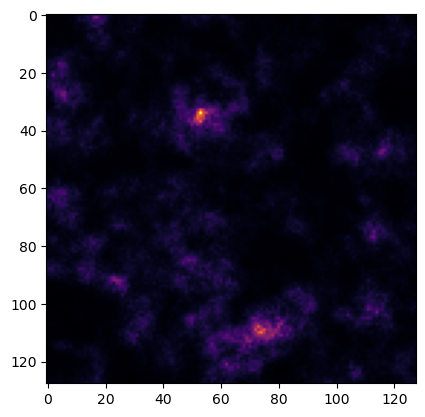

In [287]:
sim = Sim(bounds = draws)
s = sim.sample()
plt.imshow(s['x'], cmap='inferno')